## notes

Each estimation has a confidence, you can consider taking that into account during smoothing 

In [4]:
import matplotlib.pyplot as plt
import numpy as np


frames = np.load('frames.npy', allow_pickle=True)
labels = np.load('labels.npy', allow_pickle=True)


In [5]:
print(len(frames))

400


## Body part numbers

In [6]:
poses = frames[0]
person_at_frame = poses[0][0]
persons_pose = person_at_frame['pose']
for i in range(17):
    print(i,'\t' , persons_pose['keypoints'][i]['part'])


0 	 nose
1 	 leftEye
2 	 rightEye
3 	 leftEar
4 	 rightEar
5 	 leftShoulder
6 	 rightShoulder
7 	 leftElbow
8 	 rightElbow
9 	 leftWrist
10 	 rightWrist
11 	 leftHip
12 	 rightHip
13 	 leftKnee
14 	 rightKnee
15 	 leftAnkle
16 	 rightAnkle


In [7]:
#smoothing of length 3
def smoothing(x_arr, window_size = 3):
    smoothed = []
    for i in range(int(window_size/2),int(len(x_arr)-window_size/2)):
        smoothed.append(.333 * x_arr[i-1] + .333 * x_arr[i] + .333 * x_arr[i + 1])
    smoothed.append(np.mean(smoothed))
    smoothed.append(np.mean(smoothed))
    smoothed.append(np.mean(smoothed))
    return smoothed

def distance_matrix(pose):
    mat = np.zeros((len(pose),len(pose)))
    for i, part1 in enumerate(pose):
        for j, part2 in enumerate(pose):
            mat[i][j] = np.sqrt((part1['x'] - part2['x'])**2 + (part1['y'] - part2['y'])**2)
    return mat

 :) 

## Calculating distances between body part differences

In [31]:
from scipy.signal import savgol_filter
distance_matrix = []
distance_matrix_smoothed = []

for i in range(len(frames)):
    xy_arr = []
    poses = frames[i]
    for pose in poses:
        ## first grab person [0] then grab 'pose' 'then keypoints' then 'body part number'
        ## then grab 'position ' {'x', 'y'}
        xvalue = pose[0]['pose']['keypoints'][6]['position']['x']
        yvalue = pose[0]['pose']['keypoints'][6]['position']['y']
        xy_arr.append([xvalue, yvalue])
    xy_arr2 = []
    poses = frames[i]
    for pose in poses:
        ## first grab person [0] then grab 'pose' 'then keypoints' then 'body part number'
        ## then grab 'position ' {'x', 'y'}
        xvalue = pose[0]['pose']['keypoints'][14]['position']['x']
        yvalue = pose[0]['pose']['keypoints'][14]['position']['y']
        xy_arr2.append([xvalue, yvalue])
    distances = []
    distances_smooth = []
    for xyi, xyj in zip(xy_arr, xy_arr2):
        distance = np.sqrt((xyi[0] - xyj[0])**2 +(xyi[1] - xyj[1])**2 )
        distances.append(distance)
    yhat = savgol_filter(distances, 15, 2)
    distance_matrix.append(distances)
    distance_matrix_smoothed.append(yhat)    
print(np.asarray(distance_matrix_smoothed).shape)

(400,)


Proof of smoothing

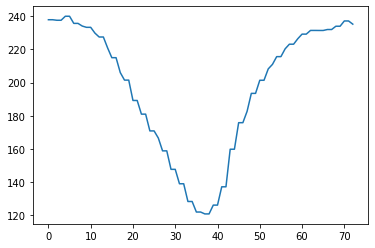

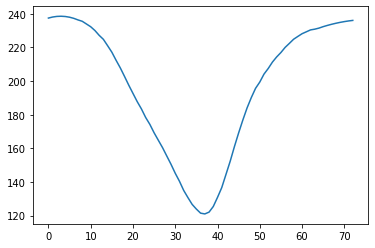

In [21]:
i = 2
plt.figure()
plt.plot(distance_matrix[i])
plt.figure()
plt.plot(distance_matrix_smoothed[i])

Study differences between the two classes

In [36]:
## Separate the two classes
good_matrix = []
bad_matrix = []
for i in range(len(distance_matrix_smoothed)):
    print(i)
    if(labels[i] == 0):
        good_matrix.append(distance_matrix_smoothed[i])
    else:
        bad_matrix.append(distance_matrix_smoothed[i])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

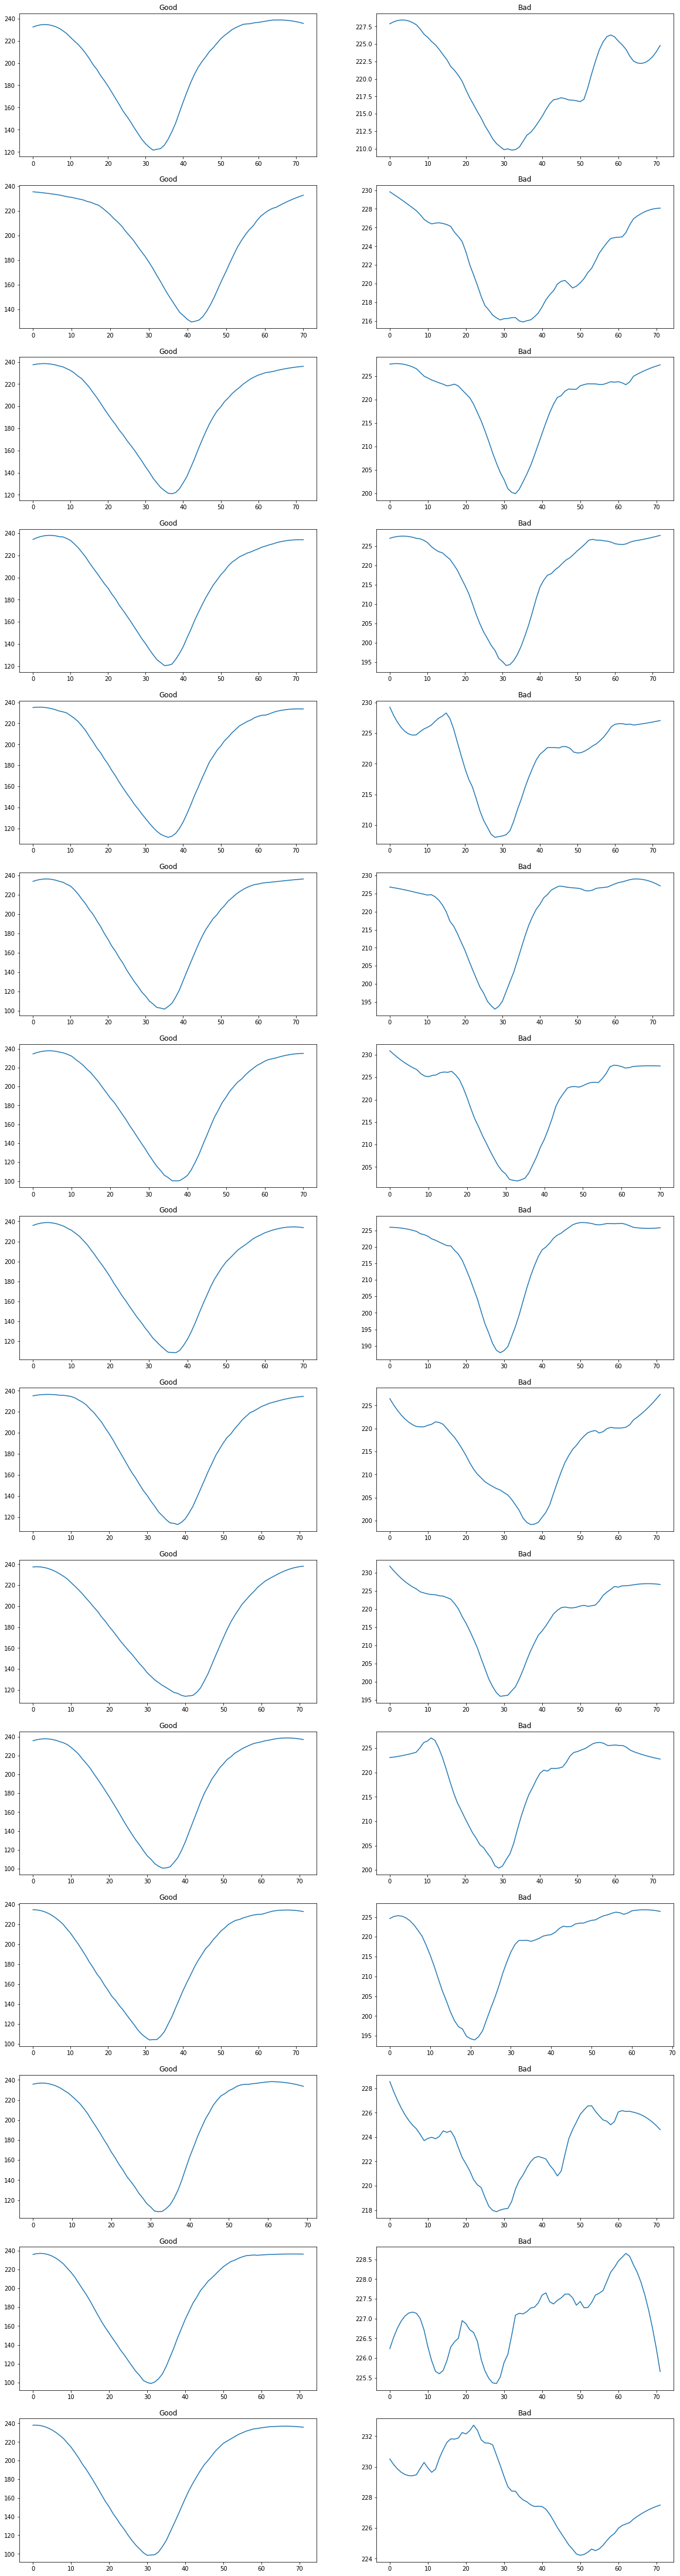

In [39]:

amount = 15
plt.figure(figsize=(20,80))
for i in range(amount):
    plt.subplot(amount, 2, 2*i + 1)
    plt.plot(good_matrix[i])
    plt.title('Good')
    
    plt.subplot(amount,2,2*i+2)
    plt.plot(bad_matrix[i])
    plt.title('Bad')

Downsampling

In [252]:
import scipy
resampled_smoothed = []
desample_to = 16
for signal in distance_matrix_smoothed:
    resampled_smoothed.append(scipy.signal.resample(signal, desample_to))

Text(0.5, 1.0, 'Shoulder trajectory')

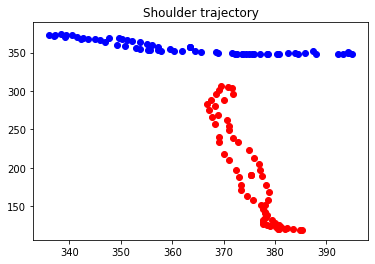

In [79]:
xy_arr = np.asarray(xy_arr)
xy_arr2 = np.asarray(xy_arr2)
## apply smoothing
xy_arr[:,0] = smoothing(xy_arr[:,0])
xy_arr[:,1] = smoothing(xy_arr[:,1])
xy_arr2[:,0] = smoothing(xy_arr2[:,0])
xy_arr2[:,1] = smoothing(xy_arr2[:,1])
plt.scatter(xy_arr[:,0], xy_arr[:,1], color='red')
plt.scatter(xy_arr2[:,0], xy_arr2[:,1], color='blue')
plt.title("Shoulder trajectory")

## We need to normalize signals to the same length so that classification is invariant to speed of squat

I think 10 is good density

In [42]:
# import scipy.signal

# distance_matrices = []
# for frame in raw_frames:
#     distance_matrices.append(distance_matrix(frame))

    
# length = np.asarray(distance_matrices).shape[0]
# desample_to = 10
# # downsampled = scipy.signal.decimate()
# #normalize samples
# distance_matrices = np.asarray(distance_matrices).reshape(total,total,length)
# #subtract mean and divide by max to get all signals in between -1 and 1
# distance_matrices = (distance_matrices.reshape(length,total,total) - np.mean(distance_matrices, axis=2))/np.max(distance_matrices, axis=2)


# distance_matrices = np.asarray(distance_matrices).reshape(total,total,length)
# new_mat = np.zeros((total,total,desample_to))
# for i in range(distance_matrices.shape[0]):
#     for j in range(distance_matrices.shape[1]):
#         signal = scipy.signal.resample(distance_matrices[i][j], desample_to)
#         new_mat[i][j] = signal
# print(new_mat.shape)

we now have a signal in a form that is ready to be classified.

## Final pipelines combining the parts
add smoothing strill

In [63]:
import scipy.signal
exclude = [9,10,8,7,4,3,1,2]
include = [0,1]
total = len(include)
raw_raw_frames = []
for i in range(len(frames)):
    poses = frames[i]
    raw_frames = []
    for pose in poses:
        ## first grab person [0] then grab 'pose' 'then keypoints' then 'body part number'
        ## then grab 'position ' {'x', 'y'}
        body_positions = []
        for i in range(len(pose[0]['pose']['keypoints'])):
            if i in include:
                value = pose[0]['pose']['keypoints'][i]['position']
                body_positions.append(value)
        raw_frames.append(body_positions)
    raw_raw_frames.append(raw_frames)

#smoothing of length 3
def smoothing(x_arr, window_size = 3):
    smoothed = []
    for i in range(int(window_size/2),int(len(x_arr)-window_size/2)):
        smoothed.append(.333 * x_arr[i-1] + .333 * x_arr[i] + .333 * x_arr[i + 1])
    smoothed.append(np.mean(smoothed))
    smoothed.append(np.mean(smoothed))
    smoothed.append(np.mean(smoothed))
    return smoothed

def distance_matrix(pose):
    mat = np.zeros((len(pose),len(pose)))
    for i, part1 in enumerate(pose):
        for j, part2 in enumerate(pose):
            mat[i][j] = np.sqrt((part1['x'] - part2['x'])**2 + (part1['y'] - part2['y'])**2)
    return mat

data2 = []
for raw_frame in raw_raw_frames:
    distance_matrices = []
    for frame in raw_frames:
        distance_matrices.append(distance_matrix(frame))


    length = np.asarray(distance_matrices).shape[0]
    desample_to = 10
    # downsampled = scipy.signal.decimate()
    #normalize samples
    distance_matrices = np.asarray(distance_matrices).reshape(total,total,length)
    #subtract mean and divide by max to get all signals in between -1 and 1
    distance_matrices = (distance_matrices.reshape(length,total,total))/np.max(distance_matrices, axis=2)
    print(np.mean(distance_matrices.reshape(total,total,length)))
    distance_matrices = distance_matrices.reshape(length,total,total) - np.mean(distance_matrices.reshape(total,total,length), axis=2)
    
    distance_matrices = np.asarray(distance_matrices).reshape(total,total,length)
    new_mat = np.zeros((total,total,desample_to))
    for i in range(distance_matrices.shape[0]):
        for j in range(distance_matrices.shape[1]):
            signal = scipy.signal.resample(distance_matrices[i][j], desample_to)
            new_mat[i][j] = signal

    new_mat = new_mat.reshape(10,total,total)
    print(new_mat.shape)
    frames2 = []
    for i in range(len(new_mat)):
        print(f'\t\t\n__\n{new_mat[i]}')
        tri = np.triu(new_mat[i], k=1).flatten()
        print(f'\n\n{tri}')
        new_curr= []
        for j in tri:
            if j != 0.:
                new_curr.append(j)
        frames2.append(new_curr)
    data2.append(frames2)
print('final shape' , np.asarray(data2).shape)

0.4539895849325708
(10, 2, 2)
		
__
[[ 0.03147314 -0.08133035]
 [-0.0208807  -0.13970559]]


[ 0.         -0.08133035  0.          0.        ]
		
__
[[-0.02763124 -0.06025956]
 [ 0.02345175 -0.00846167]]


[ 0.         -0.06025956  0.          0.        ]
		
__
[[ 0.00382216  0.0096877 ]
 [-0.03310734  0.0563943 ]]


[0.        0.0096877 0.        0.       ]
		
__
[[ 0.02275561  0.02823307]
 [-0.03458404  0.03660084]]


[0.         0.02823307 0.         0.        ]
		
__
[[-0.03399716  0.03714391]
 [ 0.04662101  0.04282092]]


[0.         0.03714391 0.         0.        ]
		
__
[[-0.05840072 -0.01520916]
 [-0.00414379 -0.03056273]]


[ 0.         -0.01520916  0.          0.        ]
		
__
[[-0.03527361 -0.06846977]
 [-0.03825894 -0.05243239]]


[ 0.         -0.06846977  0.          0.        ]
		
__
[[ 0.00208054  0.00422062]
 [ 0.07731953 -0.0043413 ]]


[0.         0.00422062 0.         0.        ]
		
__
[[0.01892913 0.00712457]
 [0.03854959 0.05445206]]


[0.         0.00712457 0.  



[ 0.         -0.06846977  0.          0.        ]
		
__
[[ 0.00208054  0.00422062]
 [ 0.07731953 -0.0043413 ]]


[0.         0.00422062 0.         0.        ]
		
__
[[0.01892913 0.00712457]
 [0.03854959 0.05445206]]


[0.         0.00712457 0.         0.        ]
		
__
[[0.05244564 0.03779661]
 [0.03514935 0.07997804]]


[0.         0.03779661 0.         0.        ]
0.4539895849325708
(10, 2, 2)
		
__
[[ 0.03147314 -0.08133035]
 [-0.0208807  -0.13970559]]


[ 0.         -0.08133035  0.          0.        ]
		
__
[[-0.02763124 -0.06025956]
 [ 0.02345175 -0.00846167]]


[ 0.         -0.06025956  0.          0.        ]
		
__
[[ 0.00382216  0.0096877 ]
 [-0.03310734  0.0563943 ]]


[0.        0.0096877 0.        0.       ]
		
__
[[ 0.02275561  0.02823307]
 [-0.03458404  0.03660084]]


[0.         0.02823307 0.         0.        ]
		
__
[[-0.03399716  0.03714391]
 [ 0.04662101  0.04282092]]


[0.         0.03714391 0.         0.        ]
		
__
[[-0.05840072 -0.01520916]
 [-0.00414379 -0.

0.4539895849325708
(10, 2, 2)
		
__
[[ 0.03147314 -0.08133035]
 [-0.0208807  -0.13970559]]


[ 0.         -0.08133035  0.          0.        ]
		
__
[[-0.02763124 -0.06025956]
 [ 0.02345175 -0.00846167]]


[ 0.         -0.06025956  0.          0.        ]
		
__
[[ 0.00382216  0.0096877 ]
 [-0.03310734  0.0563943 ]]


[0.        0.0096877 0.        0.       ]
		
__
[[ 0.02275561  0.02823307]
 [-0.03458404  0.03660084]]


[0.         0.02823307 0.         0.        ]
		
__
[[-0.03399716  0.03714391]
 [ 0.04662101  0.04282092]]


[0.         0.03714391 0.         0.        ]
		
__
[[-0.05840072 -0.01520916]
 [-0.00414379 -0.03056273]]


[ 0.         -0.01520916  0.          0.        ]
		
__
[[-0.03527361 -0.06846977]
 [-0.03825894 -0.05243239]]


[ 0.         -0.06846977  0.          0.        ]
		
__
[[ 0.00208054  0.00422062]
 [ 0.07731953 -0.0043413 ]]


[0.         0.00422062 0.         0.        ]
		
__
[[0.01892913 0.00712457]
 [0.03854959 0.05445206]]


[0.         0.00712457 0.  

[0.         0.00712457 0.         0.        ]
		
__
[[0.05244564 0.03779661]
 [0.03514935 0.07997804]]


[0.         0.03779661 0.         0.        ]
0.4539895849325708
(10, 2, 2)
		
__
[[ 0.03147314 -0.08133035]
 [-0.0208807  -0.13970559]]


[ 0.         -0.08133035  0.          0.        ]
		
__
[[-0.02763124 -0.06025956]
 [ 0.02345175 -0.00846167]]


[ 0.         -0.06025956  0.          0.        ]
		
__
[[ 0.00382216  0.0096877 ]
 [-0.03310734  0.0563943 ]]


[0.        0.0096877 0.        0.       ]
		
__
[[ 0.02275561  0.02823307]
 [-0.03458404  0.03660084]]


[0.         0.02823307 0.         0.        ]
		
__
[[-0.03399716  0.03714391]
 [ 0.04662101  0.04282092]]


[0.         0.03714391 0.         0.        ]
		
__
[[-0.05840072 -0.01520916]
 [-0.00414379 -0.03056273]]


[ 0.         -0.01520916  0.          0.        ]
		
__
[[-0.03527361 -0.06846977]
 [-0.03825894 -0.05243239]]


[ 0.         -0.06846977  0.          0.        ]
		
__
[[ 0.00208054  0.00422062]
 [ 0.077319

0
1


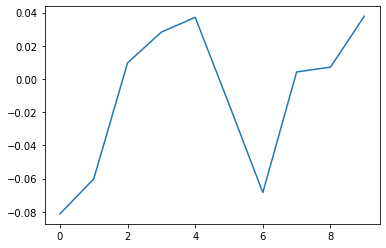

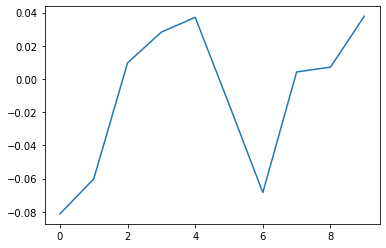

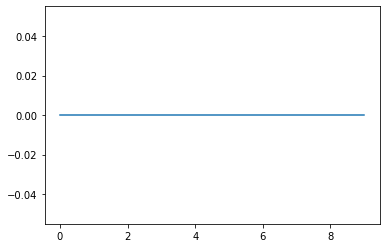

In [64]:
i=2
j=10
print(labels[i])
print(labels[j])
plt.plot(data2[i])
plt.figure()
plt.plot(data2[j])
plt.figure()
plt.plot(np.asarray(data2[i])-np.asarray(data2[j]))


In [253]:
from sklearn.model_selection import train_test_split

resampled_smoothed = np.asarray(resampled_smoothed)
# resampled_smoothed = resampled_smoothed.reshape(resampled_smoothed.shape[0], resampled_smoothed.shape[1], 1)
x_train, x_test, y_train, y_test = train_test_split(resampled_smoothed, np.asarray(labels), test_size=.1, shuffle = True)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(360, 16)
(40, 16)
(360,)
(40,)


In [ ]:
import tensorflow.keras as keras
model = keras.models.Sequential()
model.add(keras.layers.LSTM(30, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2]) ))
model.add(keras.layers.Dropout(.2))
model.add(keras.layers.LSTM(30, return_sequences=True))
model.add(keras.layers.Dropout(.2))
model.add(keras.layers.LSTM(30))
model.add(keras.layers.Dropout(.2))
model.add(keras.layers.Dense(1))
model.compile(loss = 'binary_crossentropy', 
             optimizer = keras.optimizers.Adam(lr=.5,decay=.03),
             metrics=['accuracy'],
             batch_size = 2)
model.summary()

In [ ]:
number = 50
batch = 10
print(x_train[0:number].reshape(number,x_train.shape[1],x_train.shape[2]).shape)

In [ ]:
model.fit(x_train[0:number].reshape(number,x_train.shape[1],x_train.shape[2]), y_train[0:number], epochs=10, validation_data=(x_train, y_train ), batch_size=batch)

In [ ]:
predictions = model.predict(x_train[0:number].reshape(number,x_train.shape[1],x_train.shape[2]))
print(predictions)
print("actual", y_train[0:number])

In [ ]:
data = []
targets = []
length = 200
for i in range (500):
    x = np.linspace(-5*np.pi, 5*np.pi, length)
    sinwave = np.sin(x)
    coswave = np.cos(x)
    sinwave +=  .00001*np.random.normal(0, size=length)
    coswave +=  .00001*np.random.normal(0, size=length)
    data.append(sinwave)
    data.append(coswave)
    targets.append(0)
    targets.append(1)
    

In [ ]:
plt.figure()
plt.plot(data[0])
plt.figure()
plt.plot(data[1])

In [86]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(np.asarray(data).reshape(len(data),data[0].shape[0],1), np.asarray(targets), test_size =.1, shuffle = True)

NameError: name 'data' is not defined

In [ ]:
print(x_train.shape)

In [266]:
import tensorflow.keras as keras
model = keras.models.Sequential()
model.add(keras.layers.Dense(12, input_shape=(x_train.shape[1],)))
model.add(keras.layers.Dropout(.2))
model.add(keras.layers.Dense(12))
model.add(keras.layers.Dropout(.2))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', 
             optimizer = keras.optimizers.Adam(lr=.3,decay=.005),
             metrics=['accuracy'],
             batch_size = 32)
model.summary()

Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_100 (Dense)            (None, 12)                204       
_________________________________________________________________
dropout_161 (Dropout)        (None, 12)                0         
_________________________________________________________________
dense_101 (Dense)            (None, 12)                156       
_________________________________________________________________
dropout_162 (Dropout)        (None, 12)                0         
_________________________________________________________________
dense_102 (Dense)            (None, 1)                 13        
Total params: 373
Trainable params: 373
Non-trainable params: 0
_________________________________________________________________


In [267]:
number = len(x_train)
batch = 12
# print(x_train[0:number].reshape(number,x_train.shape[1],x_train.shape[2]).shape)

In [268]:
model.fit(x_train[0:number].reshape(number,x_train.shape[1]), y_train[0:number], epochs=30, validation_data=(x_test,y_test ), batch_size=batch)

Train on 360 samples, validate on 40 samples
Epoch 1/30
360/360 [==============================] - 1s 2ms/sample - loss: 1093.9521 - accuracy: 0.4917 - val_loss: 398.7455 - val_accuracy: 0.4750
Epoch 2/30
360/360 [==============================] - 0s 220us/sample - loss: 112.6179 - accuracy: 0.5806 - val_loss: 26.8786 - val_accuracy: 0.7000
Epoch 3/30
360/360 [==============================] - 0s 222us/sample - loss: 15.2382 - accuracy: 0.8417 - val_loss: 3.3424 - val_accuracy: 0.9500
Epoch 4/30
360/360 [==============================] - 0s 231us/sample - loss: 2.3105 - accuracy: 0.9083 - val_loss: 1.8126 - val_accuracy: 0.9000
Epoch 5/30
360/360 [==============================] - 0s 203us/sample - loss: 2.1716 - accuracy: 0.8944 - val_loss: 0.6095 - val_accuracy: 0.9000
Epoch 6/30
360/360 [==============================] - 0s 203us/sample - loss: 1.7424 - accuracy: 0.9194 - val_loss: 1.6335 - val_accuracy: 0.9000
Epoch 7/30
360/360 [==============================] - 0s 204us/sample - 

In [226]:
from sklearn.svm import NuSVC
from sklearn.metrics import accuracy_score

model = NuSVC(gamma=.001, nu=.5)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(accuracy_score(y_test,y_pred))

ValueError: Found array with dim 3. Estimator expected <= 2.